##1: IMPORT LIBRARIES AND DATASETS

In [55]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Volkswagen India/Emotion Dataset/


# Import the necessary packages

import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Volkswagen India/Emotion Dataset


##2: IMPORT & EXPLORE DATASET FOR FACIAL EXPRESSION DETECTION

In [56]:
# read the csv files for the facial expression data
facialexpression_df = pd.read_csv('icml_face_data.csv')

#facialexpression_df
#facialexpression_df[' pixels'][0] # String format

# function to convert pixel values in string format to array format
def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

# Resize images from (48, 48) to (96, 96)
def resize(x):
  img = x.reshape(48, 48)
  return cv2.resize(img, dsize=(96, 96), interpolation = cv2.INTER_CUBIC)


In [57]:
print(facialexpression_df.shape)
print(facialexpression_df[' pixels'])

(24568, 2)
0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3        20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4        77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
                               ...                        
24563    0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...
24564    181 177 176 156 178 144 136 132 122 107 131 16...
24565    178 174 172 173 181 188 191 194 196 199 200 20...
24566    17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
24567    30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...
Name:  pixels, Length: 24568, dtype: object


In [58]:

facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: string2array(x))

facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: resize(x))

facialexpression_df.head()

# check the shape of data_frame
facialexpression_df.shape

(24568, 2)

In [59]:
print(facialexpression_df.shape)
print(facialexpression_df[' pixels'])

(24568, 2)
0        [[69.316925, 73.03865, 79.13719, 84.17186, 85....
1        [[151.09435, 150.91393, 150.65791, 148.96367, ...
2        [[23.061905, 25.50914, 29.47847, 33.99843, 36....
3        [[20.083221, 19.079437, 17.398712, 17.158691, ...
4        [[76.26172, 76.54747, 77.001785, 77.7672, 78.4...
                               ...                        
24563    [[-4.901001, 5.6496277, 22.477203, 49.366516, ...
24564    [[181.71645, 179.72063, 176.40785, 175.93037, ...
24565    [[178.1166, 176.83118, 174.74146, 172.61276, 1...
24566    [[16.883408, 16.953583, 17.081573, 16.53476, 1...
24567    [[30.199814, 29.574478, 28.545822, 27.846603, ...
Name:  pixels, Length: 24568, dtype: object


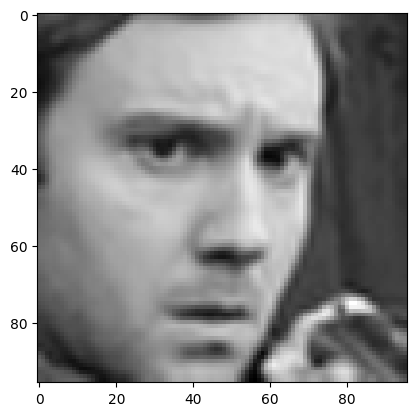

In [60]:
# check for the presence of null values in the data frame
facialexpression_df.isnull().sum()
label_to_text = {0:'anger', 1:'disgust', 2:'sad', 3:'happiness', 4: 'surprise'}

#12: Visualize the first image in the dataframe and make sure that the image is not distorted by resizing or reshaping operations
plt.imshow(facialexpression_df[' pixels'][0], cmap = 'gray')

##3: VISUALIZE IMAGES AND PLOT LABELS

In [ ]:
emotions = [0, 1, 2, 3, 4]

for i in emotions:
  data = facialexpression_df[facialexpression_df['emotion'] == i][:1]
  img = data[' pixels'].item()
  img = img.reshape(96, 96)
  plt.figure()
  plt.title(label_to_text[i])
  plt.imshow(img, cmap = 'gray')

In [ ]:
# Plot bar chart to outline how many samples (images) are present per emotion

facialexpression_df.emotion.value_counts().index

facialexpression_df.emotion.value_counts()

plt.figure(figsize = (10,10))
sns.barplot(x = facialexpression_df.emotion.value_counts().index, y = facialexpression_df.emotion.value_counts())

##4: PERFORM DATA PREPARATION AND IMAGE AUGMENTATION

In [63]:
# split the dataframe in to features and labels
from keras.utils import to_categorical

X = facialexpression_df[' pixels']
y = to_categorical(facialexpression_df['emotion'])

print(X.shape, y.shape)
X = np.stack(X, axis = 0)
X = X.reshape(24568, 96, 96, 1)

print(X.shape, y.shape)


(24568,) (24568, 5)
(24568, 96, 96, 1) (24568, 5)


In [64]:
# split the dataframe in to train, test and validation data frames

from sklearn.model_selection import train_test_split

X_train, X_Test, y_train, y_Test = train_test_split(X, y, test_size = 0.01, shuffle = True)
X_val, X_Test, y_val, y_Test = train_test_split(X_Test, y_Test, test_size = 0.5, shuffle = True)

print(X_val.shape, y_val.shape)

print(X_Test.shape, y_Test.shape)

print(X_train.shape, y_train.shape)

(123, 96, 96, 1) (123, 5)
(123, 96, 96, 1) (123, 5)
(24322, 96, 96, 1) (24322, 5)


In [65]:
# image pre-processing

X_train = X_train/255
X_val   = X_val /255
X_Test  = X_Test/255


train_datagen = ImageDataGenerator(
rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest")

In [66]:
#Try at least 2 additional data augmentation techniques

train_datagen = ImageDataGenerator(
rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range = [1.1, 1.5],
    fill_mode = "nearest")

# Note on "Brightness_range"
# 1.0 does not affect image brightness
# numbers less than 1.0 darken the image [0.5, 1.0]
# numbers larger than 1.0 brighten the image [1.0, 1.5]


##5: BUILD AND TRAIN DEEP LEARNING MODEL FOR FACIAL EXPRESSION CLASSIFICATION

In [67]:
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [68]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - stage
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128, 128, 512], stage= 3)

# 4 - stage
# X = res_block(X, filter= [256, 256, 1024], stage= 4)

# Average Pooling
X = AveragePooling2D((4, 4), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_2_emotion = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model_2_emotion.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 1,174,021
Trainable params: 1,165,445
Non-trainable params: 8,576
__________________________________________________________________________________________________


In [69]:
# train the network
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

# Recall that the first facial key points model was saved as follows: FacialKeyPoints_weights.hdf5 and FacialKeyPoints-model.json

# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "FacialExpression_weights.hdf5", verbose = 1, save_best_only=True)


# Added by Abhijeet to resolve error

with open('emotion.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture
model_2_emotion = tf.keras.models.model_from_json(json_savedModel)
model_2_emotion.load_weights('weights_emotions.hdf5')
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [70]:
history = model_2_emotion.fit(train_datagen.flow(X_train, y_train, batch_size=64),
	validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64,
	epochs= 2, callbacks=[checkpointer, earlystopping])

# saving the model architecture to json file for future use

model_json = model_2_emotion.to_json()
with open("FacialExpression-model.json","w") as json_file:
  json_file.write(model_json)


Epoch 1/2
380/380 [==============================] - ETA: 0s - loss: 1.1444 - accuracy: 0.5192
Epoch 1: val_loss improved from inf to 0.92340, saving model to FacialExpression_weights.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


380/380 [==============================] - 56s 118ms/step - loss: 1.1444 - accuracy: 0.5192 - val_loss: 0.9234 - val_accuracy: 0.6423
Epoch 2/2
380/380 [==============================] - ETA: 0s - loss: 1.0732 - accuracy: 0.5529
Epoch 2: val_loss improved from 0.92340 to 0.53807, saving model to FacialExpression_weights.hdf5
380/380 [==============================] - 40s 107ms/step - loss: 1.0732 - accuracy: 0.5529 - val_loss: 0.5381 - val_accuracy: 0.8049


##6: ASSESS THE PERFORMANCE OF TRAINED FACIAL EXPRESSION CLASSIFIER MODEL

In [71]:
score = model_2_emotion.evaluate(X_Test, y_Test)
print('Test Accuracy: {}'.format(score[1]))

history.history.keys()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

4/4 [==============================] - 0s 10ms/step - loss: 0.4866 - accuracy: 0.8130
Test Accuracy: 0.8130081295967102


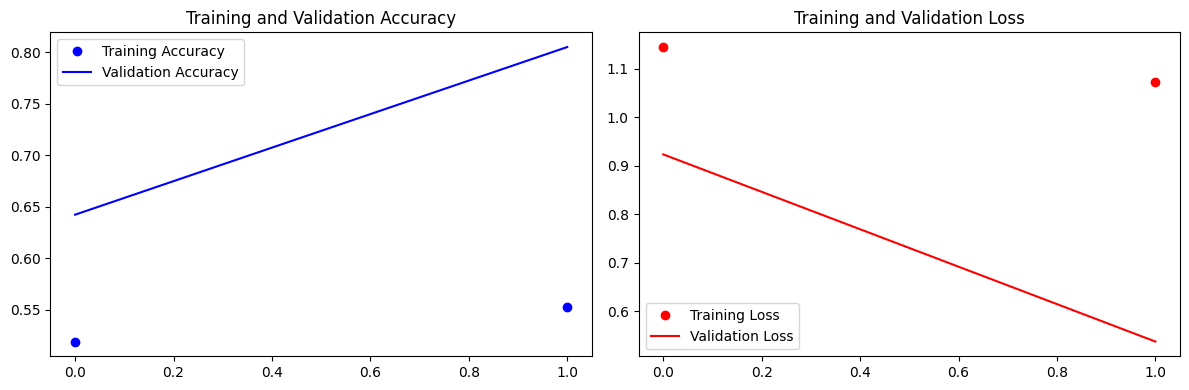

In [72]:
epochs = range(len(accuracy))

# Create a figure with two subplots (1 row, 2 columns)
plt.figure(figsize=(12, 4))  # Adjust the figure size as needed

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)  # The first subplot
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)  # The second subplot
plt.plot(epochs, loss, 'ro', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()  # Optional to improve spacing between subplots
plt.show()


In [73]:
# predicted_classes = model.predict_classes(X_test)
predicted_classes = np.argmax(model_2_emotion.predict(X_Test), axis=-1)
y_true = np.argmax(y_Test, axis=-1)

4/4 [==============================] - 0s 8ms/step


<Axes: >

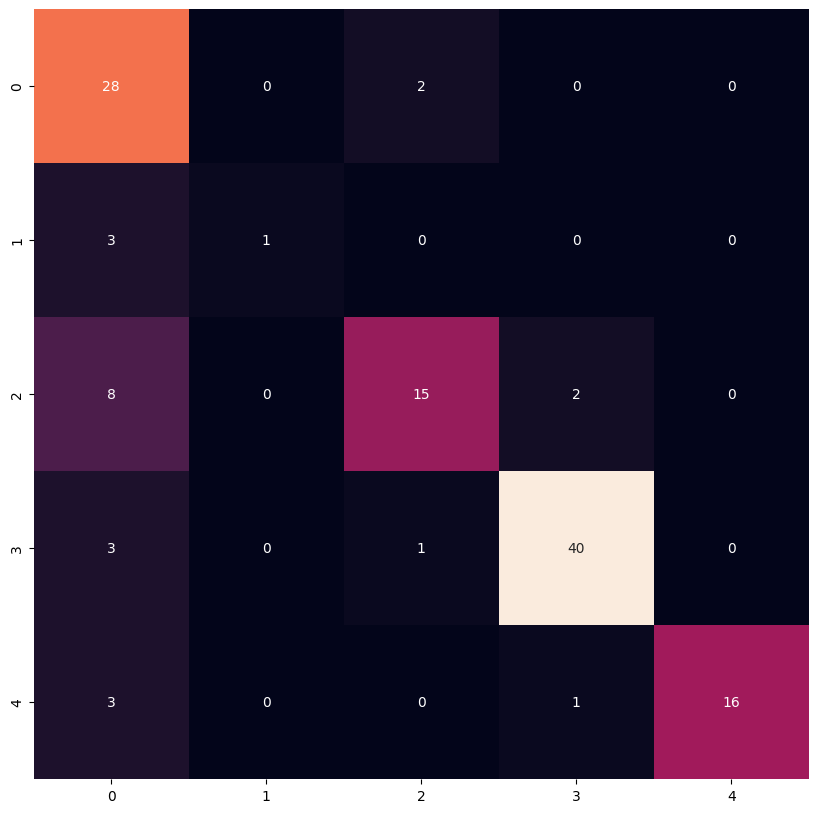

In [74]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

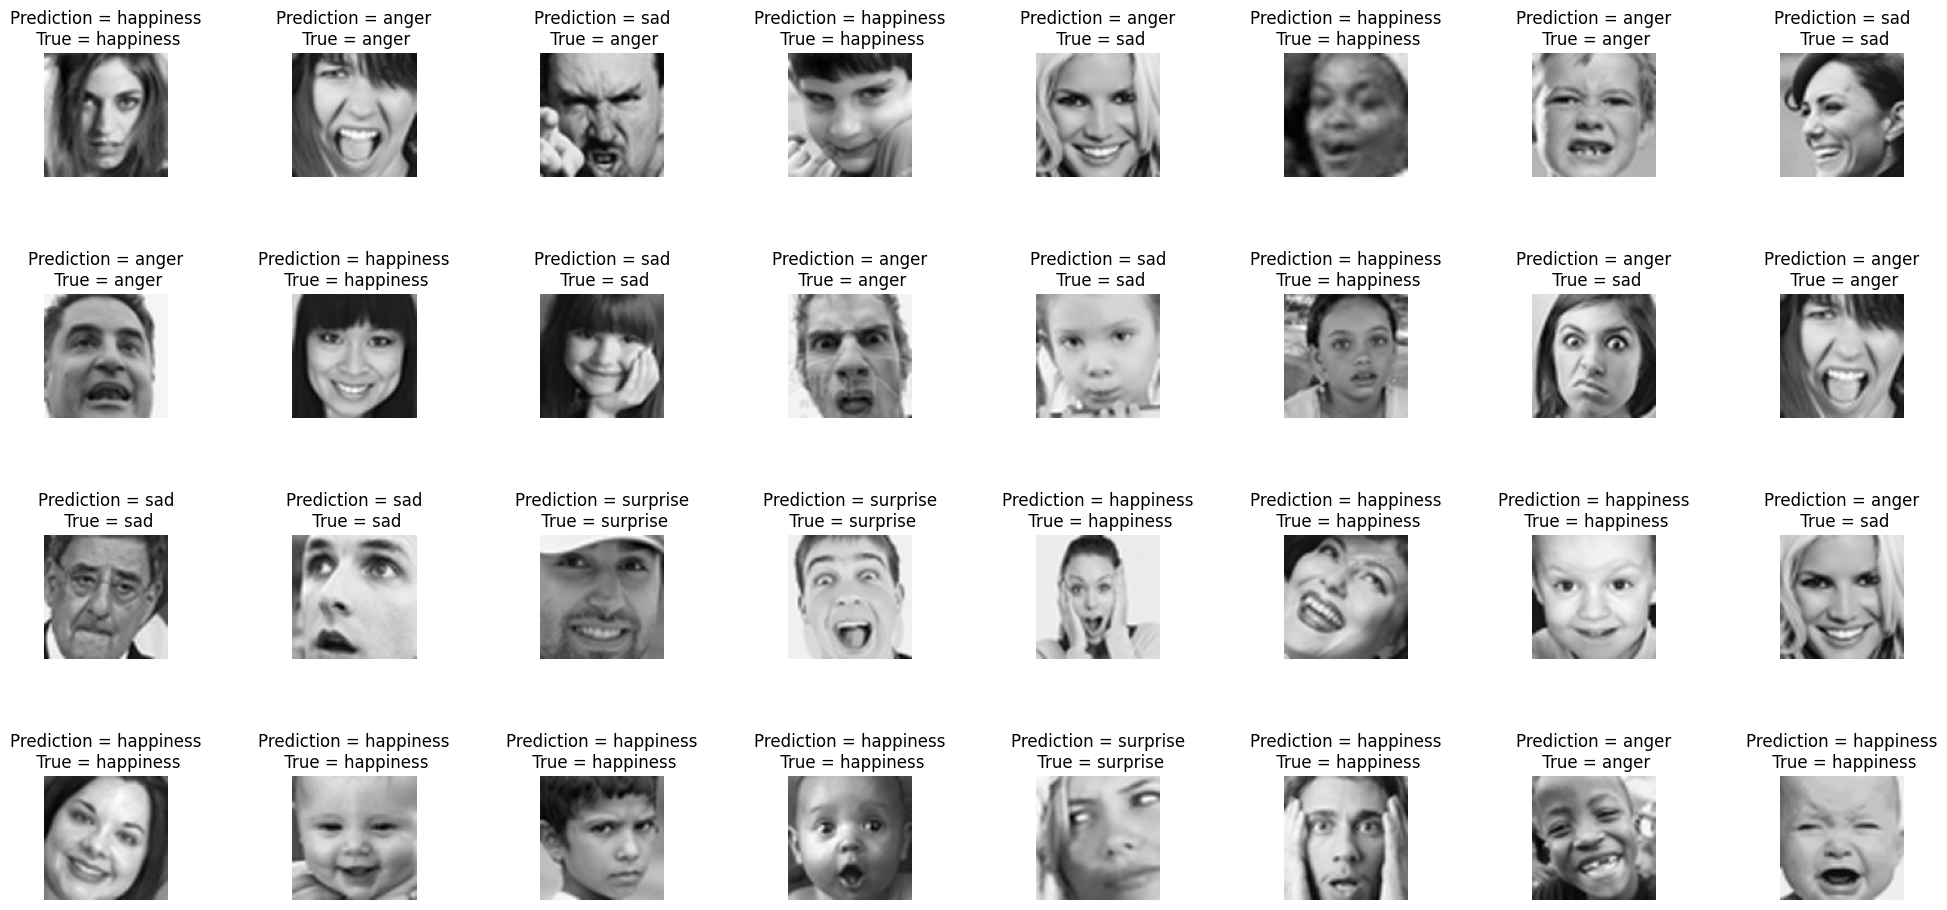

In [75]:
#Print out a grid of 25 images along with their predicted/true label
#Print out the classification report and analyze precision and recall
import random
L = 4
W = 8

fig, axes = plt.subplots(L, W, figsize = (24, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    random_integer = random.randint(0, len(X_Test))
    axes[i].imshow(X_Test[random_integer].reshape(96,96), cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)

In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.62      0.93      0.75        30
           1       1.00      0.25      0.40         4
           2       0.83      0.60      0.70        25
           3       0.93      0.91      0.92        44
           4       1.00      0.80      0.89        20

    accuracy                           0.81       123
   macro avg       0.88      0.70      0.73       123
weighted avg       0.85      0.81      0.81       123

